# Fictitous Play

This note demonstrates how to use `fictplay` Julia module.

In [1]:
include("fictplay.jl")
using Plots #use Plots package to draw the graph
gr()  #use GR in the backend

Plots.GRBackend()

Fictitious play is first introduced as a learning model by Brown(1951) and Robinson(1951). In fictitious play model, players choose their strategies to maximize their payoffs with the beliefs such that their opponents will play each strategy with the probability equal to its historical frequency. In this note, we focus on two-player game.

## Model

- $i=1,2$ : players
- $S_i$ : the finite set of pure strategies
    - $S = S_1 \times S_2$ : the set of pure strategy profile
    - $s_i \in S_i$ : one of the $i$'s pure strategy
- $\Sigma_i$ : the set of mixed strategies
    - $\Sigma = \Sigma_1 \times \Sigma_2$ : the set of mixed strategy profile
    - $\sigma_i \in \Sigma_i$ : one of the $i$'s mixed strategy.
- $u_i(s_i, \sigma_{-i})$ : $i$'s expected utility when he chooses pure strategy $s_i$ and his opponent plays according to $\sigma_{-i}$ 

After each round of play, players observe the actual actions choosen by opponents, and they choose strategies in the next round given histories of opponents actions. When a player choose a mixed strategy, its mixing is not observed, that is, histories of play consist of pure-strategy profiles.

- $t = 1, 2, \cdots$: dates
- $s^{\tau} \in S$ : strategy profile at date $\tau$
- $\zeta^t = (s^1, \cdots, s^{t-1})$ : history of play up to $t$
    - $\zeta^1$ indicates null history
- $\mathcal{Z}^t$ : the set of all histories of play up to $t$
    - by construction, $\mathcal{Z}^1$ is the singleton set consisting of the null history
    - $\mathcal{Z}$ : the set of all possible infinite histories
- $\kappa(\zeta^t)(s_i)$ : the number of times that $i$ played $s_i$ in the $t-1$ observations that comprise $\zeta^t$
    - player $i$ has an exogenous initial weight function $\kappa_i(\zeta^1) : S_{-i} \rightarrow \mathcal{R}_+$

Weight function is updated by adding 1 to the weight of each opponent strategy each time it is played so that:

\begin{equation}
\kappa_i(\zeta^t)(s_{-i}) = \kappa_i(\zeta^{t-1})(s_{-i}) + \left\{ \begin{array}{ll}
    1 & (s_{-i}^{t-1} = s_{-i}) \\
    0 & (s_{-i}^{t-1} \neq s_{-i})
  \end{array} \right.
\end{equation}

Each player assesses concerning the behavior of his opponents at each date and contingent on history

- $\mu_i^t : \mathcal{Z}^t \rightarrow \Sigma_{-i}$ : $i$'s assessment over the possible pure-strategy profiles that hisopponents will choose at date $t$

Then, $\mu_i$ is given by normalizing the $\kappa_i$, that is,

\begin{equation}
\mu_i^t (\zeta^t)(s_{-i}) = \frac{\kappa_i (\zeta^t)(s_{-i})}{\sum_{\tilde{s}_{-i} \in S_{-i}}\kappa_i (\zeta^t)(\tilde{s}_{-i})}
\end{equation}

Each player takes best response, which is a maximizer of 
\begin{equation}
\sum_{s_{-i} \in S_{-i}} u_i(\sigma_i, s_{-i}) \mu_i^t (\zeta^t)(s_{-i})
\end{equation}
over all $\sigma_i \in \Sigma_i$

It is well known that if fictitious play converges to some distribution, those possibilities correspond to Nash equilibrium. However, fictitious play does not always converge. It converges for a two-player game when, for example

- Both players have finite strategies and the game is a zero-sum game
- The game is a potential game
- The game is solvable by IESDS

## Fictitious Play

Let's consider the FictitiousPlay model with the following **matching pennies** payoff matrix

1$\backslash$2 | $A$           | $B$ 
 ------------- |---------------| ---------
 $A$           | 1, -1          |    -1, 1   
 $B$           | -1, 1          |   1, -1    

In [2]:
matching_pennies_bimatrix = Array{Float64}(undef, 2, 2, 2)
matching_pennies_bimatrix[:, 1, 1] = [1, -1]
matching_pennies_bimatrix[:, 1, 2] = [-1, 1]
matching_pennies_bimatrix[:, 2, 1] = [-1, 1]
matching_pennies_bimatrix[:, 2, 2] = [1, -1]
g = NormalFormGame(matching_pennies_bimatrix)

2×2 NormalFormGame{2,Float64}

Create a `FictitiousPlay` type with this `NormalFormGame` instance

In [3]:
mp = FictitiousPlay(g)

FictitiousPlay{2}(2×2 NormalFormGame{2,Float64})

### `get_iterate_result`

`get_iterate_result` method returns the result of iteration. This methods requires at least two arguments, `FictitiousPlay` instance and `ts_length`.  The game `FictitiousPlay` instance indicates is used to simulate fictitous play model. `ts_length` is the number of rounds you want to play. `ts_length` must be `Int` type. In addition, you can designate the first actions via `init_actions` which must be `Action` or `ActionProfile` instance. If you don't specify `init_actions`, the actions in the first round are determined randomly.

When you want to know the players' assessments after 1000 times iteration, with the initial action $(1,1)$, try the following code:

In [4]:
ts_length = 1000
init_actions = [1,1]
get_iterate_result(mp,ts_length,init_actions)

2-element Array{Array{Float64,1},1}:
 [0.513487, 0.486513]
 [0.492507, 0.507493]

### `get_time_series`

`get_time_series` method returns the time series of players' assessments in each round. Similarly, you can set initial actions via `init_actions`.

In [5]:
ts_length = 10
init_actions = [1,1]
assessments = get_time_series(mp,ts_length,init_actions)

2-element Array{Array{Any,1},1}:
 [[1.0, 0.0], [0.5, 0.5], [0.333333, 0.666667], [0.25, 0.75], [0.2, 0.8], [0.166667, 0.833333], [0.142857, 0.857143], [0.25, 0.75], [0.333333, 0.666667], [0.4, 0.6]]
 [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [0.75, 0.25], [0.6, 0.4], [0.5, 0.5], [0.428571, 0.571429], [0.375, 0.625], [0.333333, 0.666667], [0.3, 0.7]]                  

Let make it easy to see.

In [6]:
#Player 1's assessments in each round
for i in 1:ts_length
    println("Round $i :", assessments[1][i])
end

Round 1 :[1.0, 0.0]
Round 2 :[0.5, 0.5]
Round 3 :[0.333333, 0.666667]
Round 4 :[0.25, 0.75]
Round 5 :[0.2, 0.8]
Round 6 :[0.166667, 0.833333]
Round 7 :[0.142857, 0.857143]
Round 8 :[0.25, 0.75]
Round 9 :[0.333333, 0.666667]
Round 10 :[0.4, 0.6]


In [7]:
#Player 2's assessments in each round
for i in 1:ts_length
    println("Round $i :", assessments[2][i])
end

Round 1 :[1.0, 0.0]
Round 2 :[1.0, 0.0]
Round 3 :[1.0, 0.0]
Round 4 :[0.75, 0.25]
Round 5 :[0.6, 0.4]
Round 6 :[0.5, 0.5]
Round 7 :[0.428571, 0.571429]
Round 8 :[0.375, 0.625]
Round 9 :[0.333333, 0.666667]
Round 10 :[0.3, 0.7]


## Simulations

### Two-actions game

Let's simulate fictitious play model with matching pennies game defined above.

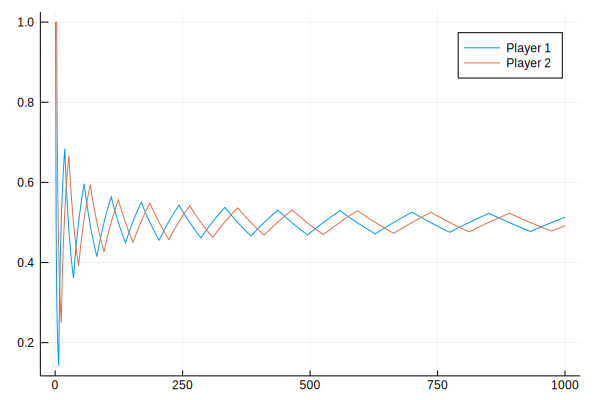

In [8]:
ts_length = 1000
init_actions = [1,1]
assessments_series = get_time_series(mp,ts_length,init_actions)
assessments = [[assessments_series[1][t][1] for t in 1:ts_length], [assessments_series[2][t][1] for t in 1:ts_length]]
labels = ["Player 1", "Player 2"]
plot(assessments, label=labels)

Horizontal and vertical axis correspond to the period and the player's belief for his opponent's first action. Blue(Orange) line represents first(second) player's belief. As you can see, both players' assesements converge to $(0.5, 0.5)$, which is the maixed strategy Nash Equilibrium of this game. This result is consistent with manu papers.

### Three-actions game

Consider the fictitious play model of shapley game whose payoff matrix is

1$\backslash$2 | $A$           | $B$    |$C$
 ------------- |---------------| ---------|-----------
 $A$           | 0, 0          |    1, 0   |   0,1
 $B$           | 0, 1          |   0, 0   |    1,0
 $C$           |1,0           | 0,1      | 0,0

In [9]:
shapley_game = Array{Int}(undef, 3, 3, 2)
shapley_game[:, 1, 1] = [0, 0, 1]
shapley_game[:, 2, 1] = [1, 0, 0]
shapley_game[:, 3, 1] = [0, 1, 0]
shapley_game[:, 1, 2] = [0, 1, 0]
shapley_game[:, 2, 2] = [0, 0, 1]
shapley_game[:, 3, 2] = [1, 0, 0]
g = NormalFormGame(shapley_game)

3×3 NormalFormGame{2,Int64}

Create a `FictitiousPlay` instance

In [10]:
sg = FictitiousPlay(g)

FictitiousPlay{2}(3×3 NormalFormGame{2,Int64})

Let's simulate the fictitious play model of this game.

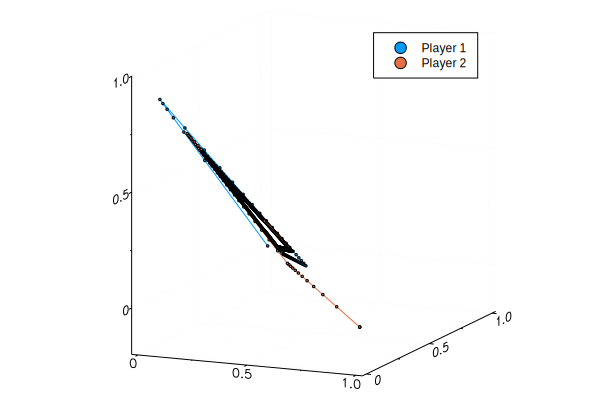

In [11]:
ts_length=1000
init_actions=[1,2]
assessment_series = get_time_series(sg, ts_length, init_actions)
X = [[assessment_series[1][t][1] for t in 1:ts_length], [assessment_series[2][t][1] for t in 1:ts_length]]
Y = [[assessment_series[1][t][2] for t in 1:ts_length], [assessment_series[2][t][2] for t in 1:ts_length]]
Z = [[assessment_series[1][t][3] for t in 1:ts_length], [assessment_series[2][t][3] for t in 1:ts_length]]
labels = ["Player 1", "Player 2"]
plot(X,Y,Z,label=labels,marker=:circle, markersize=1)

X-axis(bottom right), y-axis(bottom left) and z-axis(vertical axis) correspond to player's belief for opponent's first, second third action respectively. Blue(Red) points represent first(second) player's belief at each period for opponent's action.

Shapley(1964) showed that in the normal fictitious play (not weighted fictitious play) if $(A, B)$ is choosen in the first period, then players' beliefs do not converge. In addition, the fictitious play follows the cycle $(A, B) \rightarrow (A, C) \rightarrow (B, C) \rightarrow (B,A) \rightarrow (C,A) \rightarrow (C, B) \rightarrow (A, B) \rightarrow \cdots$

# Stochastic Fictitous Play

Stochastic fictitious play is first introduced by Fundenberg and Kreps(1993). In this model, each player's payoff is perturbed in each period by a random shock.

## Model

Almost all of the settings are same as original fictitious play model except for paerturbated payoff. Player's payoff at period $t$ is given by 

\begin{equation}
u_i^t (s_i^t, s_{-i}^t) + \eta_i(s_i^t)
\end{equation}

The random payoff shock $\eta_i$ is observable for each $i$, but player $i$ cannot observe opponents' payoff shock and its history. Let $\rho_i$ denote the probability distribution of each $\eta_i$ and $E_i$ denote the support of $\rho_i$.

In each period, players choose their strategy after observing payoff shock, so in the stage game strategy for each player is a mapping form $E_i$ to $S_i$. Note that we do not need to consider mixed startegies in this augmented game.

Fundenberg and Kreps(1993) showed that in any $2 \times 2$ game that has a unique completely mixed Nash equilibrium, stochastic fictitious play converges with pobability 1 with some assumptions.

In adddition, Hofbauer and Sandholm (2002) showed that in (i) two-player symmetric game with an interior ESS (ii) two-player zero sum game, and some game classes, stochastic fictitious play converges.

## Stochastic Fictitious Play

`fictplay` module also provides `StochasticFictitiousPlay` type. Each payoff shock follows same distribution, **gumbel distribution** or **standard normal distribution**, that is, $\eta_i(\cdot) \sim Gumbel(\mu, \beta)$ or $\eta_i(\cdot) \sim N(0, 1)$ for all $i$. $\eta_i(s_i)$ ($i = 1,2$, $s_i \in S_i$) are independent and identically distributed.

Similar to `FictitiousPlay` type, we have the functions `get_iterate_result` and `get_time_series`.

## Simulations

### Two-action Game

In [12]:
g = NormalFormGame(matching_pennies_bimatrix)
mp = StochasticFictitiousPlay(g, :extreme)

StochasticFictitiousPlay{2}(2×2 NormalFormGame{2,Float64}, :extreme)

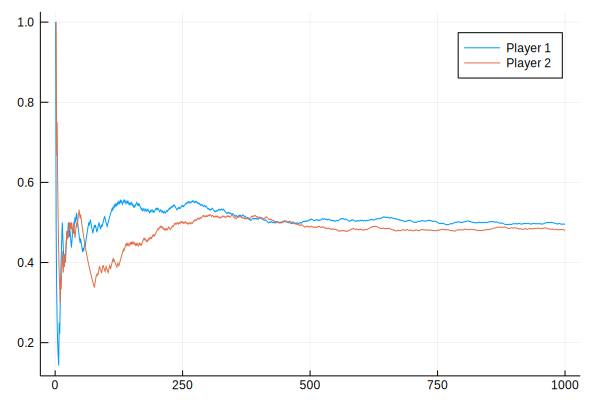

In [13]:
ts_length = 1000
init_actions = [1,1]
assessments_series = get_time_series(mp,ts_length,init_actions)
assessments = [[assessments_series[1][t][1] for t in 1:ts_length], [assessments_series[2][t][1] for t in 1:ts_length]]
labels = ["Player 1", "Player 2"]
plot(assessments, label=labels)

### Three-action Game

In [14]:
g = NormalFormGame(shapley_game)
sg = StochasticFictitiousPlay(g, :extreme)

StochasticFictitiousPlay{2}(3×3 NormalFormGame{2,Int64}, :extreme)

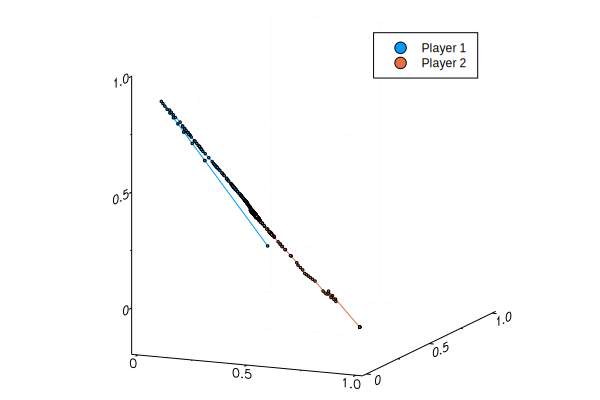

In [15]:
ts_length=1000
init_actions=[1,2]
assessment_series = get_time_series(sg, ts_length, init_actions)
X = [[assessment_series[1][t][1] for t in 1:ts_length], [assessment_series[2][t][1] for t in 1:ts_length]]
Y = [[assessment_series[1][t][2] for t in 1:ts_length], [assessment_series[2][t][2] for t in 1:ts_length]]
Z = [[assessment_series[1][t][3] for t in 1:ts_length], [assessment_series[2][t][3] for t in 1:ts_length]]
labels = ["Player 1", "Player 2"]
plot(X,Y,Z,label=labels,marker=:circle, markersize=1)